# The Problem We are Trying to Solve

You have a building connected to a bad electricity grid, and as a result, it uses a diesel generator when the power goes out. I want to compare the economics of that scenario (electricity price + cost of running diesel) against the economics of a scenario where that building uses a combination of solar, storage, and diesel.

So the model would account for the following:

Meet building electricity consumption with the optimal combination of

 * Direct solar energy production
 * Electricity from the grid
 * Electricity in battery (from solar or grid)

OR
 * Diesel generator

# Get the Data Set up

The datasets are in hourly or 15 minute intervals across a 1 year time horizon. 
In this scenario generation from #1 and #2 are intermittent but known. 
Each source of electricity has a different cost based on how often it is used or (with electricity) the time of day.

In [1]:
#import pandas a very helpful library for working with datasets, call it pd because that's easier to type than pandas
import pandas as pd

#numpy allows all sort of numeric functions; we're going to use it only as a random number generator
import numpy as np

In [2]:
#read in the file with the energy use data set. Pandas has a nice function for reading excel, csvs, sql, etc. 
energy_needs = pd.read_excel(('https://openei.org/datasets/dataset/399852d9-91a3-4dd7-86ba-73dd5388c994/'
                              'resource/c0608a74-1ef8-4583-a4cd-33f0c78e8478/download/lbnlb74electricity.xlsx'))

#the .head() function allows us to look at the top 5 rows of the dataset
energy_needs.head()

,Timestamp,Building 74 - kWh Total Electricity (kWh)
0,2014-01-01 00:30:00,22.8125
1,2014-01-01 00:45:00,24.6650
2,2014-01-01 01:00:00,24.1725
3,2014-01-01 01:15:00,24.9500
4,2014-01-01 01:30:00,23.6175


In [3]:
#rename this column because it's long and would be annoying to keep typing
energy_needs.rename(columns={'Building 74 - kWh Total Electricity (kWh)':'kWh'}, inplace=True)

#### Since the values we want to work with are mostly in terms of hours let's group by hours 


In [4]:
#first we're going to create a new timestamp with just hours instead of 15 min increments
energy_needs['timestamp_hour'] = energy_needs['Timestamp'].apply(
    lambda x: pd.Timestamp(year=x.year,month=x.month,day=x.day,hour=x.hour))


#now, using functionality like an excel pivot table, we will sum the kwH by the hour using the new timestamp
#to work with this new dataset we will give it a new name: energy

energy = energy_needs.pivot_table(index=['timestamp_hour'], 
                         values='kWh', aggfunc='sum').reset_index()

energy.head()

,timestamp_hour,kWh
0,2014-01-01 00:00:00,47.4775
1,2014-01-01 01:00:00,96.4825
2,2014-01-01 02:00:00,97.1350
3,2014-01-01 03:00:00,95.8700
4,2014-01-01 04:00:00,95.5325


### Now, let's indicate when the grid is down and the building would have to switch to an alternate power source

In [5]:
# We want to be able to set the hours the grid is down for at a time 
# and number of days per week that the grid is down

hoursdown = 4

#this groups and sums the kWh by the number of hours specified
energy_grouped = energy.groupby(energy.index / hoursdown).sum() 
energy_grouped.head()

,kWh
0,336.9650
1,408.2125
2,398.8675
3,394.5475
4,395.5950


In [6]:
# we are adding a column to the dataframe with a random number so we can randomly assign times the grid is down
energy_grouped['grid_down_probability'] = energy_grouped['kWh'].apply(lambda x: np.random.random())

In [7]:
days_per_week_grid_down = 3

# number of times it goes down out of the total number of hour chunks in a week

percent_downtime = days_per_week_grid_down / (7.0*24/hoursdown) #note you need a float in the equation to make this work
print percent_downtime

def grid_is_down(rand_num):
    # we will use a 0 to indicate that the grid is working and a 1 to indicate the grid is down
    if rand_num < percent_downtime:
        return 1
    else:
        return 0

energy_grouped['grid_down'] = energy_grouped['grid_down_probability'].apply(grid_is_down)

#we don't need the proability column anymore so we delete it to keep things clean looking
del energy_grouped['grid_down_probability']

energy_grouped.head()

0.0714285714286


,kWh,grid_down
0,336.9650,0
1,408.2125,0
2,398.8675,0
3,394.5475,0
4,395.5950,0


## Set up the Various Cost Inputs (with minimal complexity to start)

There are a few measures of cost that could be used, but the customer basically has three options to compare: 

1. Buy the equipment,
2. Lease the equipment, 
3. Purchase the energy produced. 

Each item has a capex cost and an opex cost. 
* Diesel the capex is the equipment and the opex is fuel and maintenance
* Solar the capex is the initial purchase price dollars per kW installed price and the opex is just maintenance also dollars kW
* Storage the opex is fuel (electricity from the grid) and maintenance. 

I think the best framing on the cost comparison is to assess the levelized cost of energy (kWh) for each (diesel vs. package), which is all the costs divided by the energy produced, considering some cost of capital.




In [8]:
# Diesel Variables

# annualized over 10 years, 20% rate
diesel_capex = float(100000)
payback_years = 10
interest_rate = 0.20

# you can let formulas run over several lines if you enclose them in parans
diesel_annual_payment = (diesel_capex * 
                         (interest_rate * (1 + interest_rate) ** payback_years) /
                         ((1 + interest_rate) ** payback_years - 1))


diesel_lifetime_hrs = 36000
cost_of_gas = 3.5
gallons_per_hour = 18
diesel_om_kwh = 0.02

annual_cost_increase_rate = 0.03

In [10]:
# Storage Variables

storage_kwh = 1000 
storage_lifetime_kwh = 2700*storage_kwh

# annualized over 10 years, 20% rate
storage_capex = float(350*storage_kwh)
payback_years = 10
interest_rate = 0.20

# you can let formulas run over several lines if you enclose them in parans
storage_annual_payment = (storage_capex * 
                         (interest_rate * (1 + interest_rate) ** payback_years) /
                         ((1 + interest_rate) ** payback_years - 1))

storage_electricity_rate = 0.06*0.89 # not sure why this is multiplied by 0.89?

## Calculating Total Costs

In [11]:
# Cacluate how many kWh the grid is down vs how many the grid is up:
kwh_grid_down = (energy_grouped['grid_down']*energy_grouped['kWh']).sum()
print 'Total Grid Down kWh needed %.2f' %kwh_grid_down

Total Grid Down kWh needed 116625.22


In [12]:
#Function for the diesel scenario:

diesel_total_cost = (diesel_annual_payment + #lease costs
                     kwh_grid_down*diesel_om_kwh + #operations and maintenance
                     energy_grouped['grid_down'].sum()*hoursdown*gallons_per_hour*cost_of_gas) #fuel

print 'Total Annual Diesel Cost %.2f' %diesel_total_cost

Total Annual Cost 85152.78


In [17]:
#Function for the storage scenario:

storage_total_cost = (storage_annual_payment + #lease costs
                     kwh_grid_down*storage_electricity_rate)

print 'Total Annual Storage Cost %.2f' %storage_total_cost

Total Annual Cost 89710.75


# Year 1 Energy Costs

In [20]:
from scipy import optimize

In [21]:
#variables we control:

hours = range(1,9) # a range of 1 hour down to 8 hours down
daysdown = range (1,8) # a range of days this happens from 1 to 7
costpergal = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0] #range of gas prices from $2/gal to $5/gal
leaserate = [0.15, 0.175, 0.20, 0.225, 0.25] #range of lease rates from 15% to 25%

In [22]:
# this creates a dataframe of all possible combinations of the variables above:

from itertools import product
costs_df = pd.DataFrame(list(product(hours, daysdown, costpergal,leaserate)), 
                     columns=['hoursdown', 'daysdown','costpergal','leaserate'])
costs_df.head()

,hoursdown,daysdown,costpergal,leaserate
0,1,1,2.0,0.150
1,1,1,2.0,0.175
2,1,1,2.0,0.200
3,1,1,2.0,0.225
4,1,1,2.0,0.250


In [27]:
diesel = []
storage = []

# now, for everyone of those combinations of hours down, days down, costsper gallon etc 
# we will calculate the energy cost for diesel and the energy cost for storage

for index, row in costs_df.iterrows():
    
    #these are the functions we ran above, but now doing them in a more structured fashion
    df = energy.groupby(energy.index / row['hoursdown']).sum() 
    df['grid_down_probability'] = df['kWh'].apply(lambda x: np.random.random())
    percent_downtime = row['daysdown'] / (7.0*24/row['hoursdown']) 
    df['grid_down'] = df['grid_down_probability'].apply(grid_is_down)
    kwh_grid_down = (df['grid_down']*df['kWh']).sum() #this gives us the total kWh that the grid is down

    
    #these calculate the diesel cost in this scenario for every row in the dataframe and appends to a list
    diesel_total_cost = (diesel_annual_payment + #lease costs
                     kwh_grid_down*diesel_om_kwh + #operations and maintenance
                     df['grid_down'].sum()*hoursdown*gallons_per_hour*row['costpergal']) #fuel
    diesel.append(diesel_total_cost)
        
    #now the storage costs   
    storage_total_cost = (storage_annual_payment + kwh_grid_down*storage_electricity_rate)
    storage.append(storage_total_cost)
    
costs_df['dieselcost'] = diesel
costs_df['storagecost'] = storage

In [28]:
costs_df.head()

,hoursdown,daysdown,costpergal,leaserate,dieselcost,storagecost
0,1,1,2.0,0.150,33963.268721,83950.196306
1,1,1,2.0,0.175,35721.373014,84030.574770
2,1,1,2.0,0.200,31464.512570,83814.677384
3,1,1,2.0,0.225,32788.575181,83889.604555
4,1,1,2.0,0.250,33225.783424,83903.510563


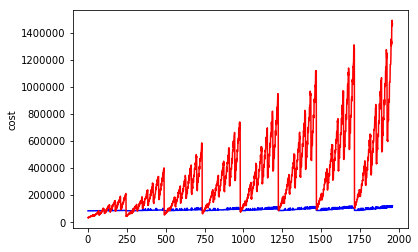

In [29]:
#we'll graph the differences in costs - though in most scenarios we are seeing the diesel cost rise so much
# that it is hard to see the increments in the storage cost

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(costs_df['storagecost'], color='b', label='Diesel') #b for blue
plt.plot(costs_df['dieselcost'], color='r', label='Storage') #r for red
plt.ylabel('cost')
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

plt.show()

## Now need to apply this to a 10 year scenario in which costs and energy needs are forecast with an increase rate